In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [32]:
# import
import numpy as np
import seaborn as sns # iris 데이터
import pandas as pd # 원핫인코딩
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자->숫자)
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출로)
from tensorflow.keras.models import Sequential, load_model, save_model 
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화

- iris 데이터
1. sepal_length : 꽃받침길이
2. sepal_width : 꽃받침길이
3. petal_length : 꽃잎길이
4. petal_width : 꽃잎너비
5. species : 종

In [11]:
# 문자변수의 원핫인코딩 방법1
iris = sns.load_dataset('iris')
# to_categorical(iris['species'])
labelEncoder = LabelEncoder()
# labelEncoder.fit(iris['species'])
# iris['y'] = labelEncoder.transform(iris['species'])
iris['y'] = labelEncoder.fit_transform(iris.species)
# iris.iloc[::25]
to_categorical(iris['y'])[::25] # to_categorical의 결과는 numpy배열

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [15]:
# 문자변수 원핫인코딩 방법 2
iris = sns.load_dataset('iris')
pd.get_dummies(iris.species).values # pd.get_dummies결과는 데이터프레임
pd.get_dummies(iris.species).to_numpy()[::25]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [28]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() 결측치 있으면 결측치 처리
# iris['species'].value_counts() 타겟변수의 분포
# 독립변수와 타겟변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values
# iris_Y[::50]
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                    train_size=0.8, # 훈련셋비율
                                                   # test_size=0.2, # 테스트비율
                                                   # stratify=iris_Y, # 층화추출
                                                   random_state=7 # 랜덤시드값
                                                   )
print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [37]:
# 층화추출이 되었는지 확인
# iris_Y.argmax(axis=1)
print(pd.Series(np.argmax(iris_Y, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_train, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_test, axis=1)).value_counts())

0    50
1    50
2    50
dtype: int64
0    43
2    39
1    38
dtype: int64
1    12
2    11
0     7
dtype: int64


In [43]:
# 2. 모델구성(입력4, 출력 3)
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax')) # 출력층
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                320       
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                6450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 30)                1530      
                                                                 
 dropout_2 (Dropout)         (None, 30)               

In [45]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습 : epoch 마다 val_accuracy값이 좋아지고 있으면 model 자동 저장(콜백추가)
    # 모델 자동 저장될 경로 : ./model/iris-002-val0.8765.h5
import os
model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델자동저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy', # 모니터링 지표(기본값 : val_loss)
                            mode='max',
                            save_best_only=True, # False : 매번 저장
                            verbose=1) # 모델저장시 로그 출력 (0:로그출력 안함)
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor 기본값은 val_loss
hist = model.fit(X_train, Y_train,
                # batch_size=40,
                epochs=500,
                validation_split=0.2, # 훈련셋의 20%를 검증셋
                callbacks=[earlyStopping, checkpoint])

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0784 - accuracy: 0.4062
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./model_iris\iris-001-val1.0000.h5
3/3 [==============================] - 1s 100ms/step - loss: 1.0625 - accuracy: 0.4167 - val_loss: 0.8837 - val_accuracy: 1.0000
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.9974 - accuracy: 0.5312
Epoch 2: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.9163 - accuracy: 0.6146 - val_loss: 0.8008 - val_accuracy: 0.7917
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.8518 - accuracy: 0.6562
Epoch 3: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 23ms/step - loss: 0.8928 - accuracy: 0.6771 - val_loss: 0.7415 - val_accuracy: 0.6250
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.8021 - accuracy: 0.6875
Epoch 4: val_accuracy did not improve

Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9375
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.1341 - accuracy: 0.9479 - val_loss: 0.1452 - val_accuracy: 0.9583
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1385 - accuracy: 0.9688
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.1222 - accuracy: 0.9688 - val_loss: 0.1393 - val_accuracy: 0.9583
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0529 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.1459 - accuracy: 0.9583 - val_loss: 0.2022 - val_accuracy: 0.9167
Epoch 34/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1496 - accuracy: 0.9375
Epoch 34: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0279 - accuracy: 1.0000
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0743 - accuracy: 0.9792 - val_loss: 0.1006 - val_accuracy: 0.9583
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0750 - accuracy: 0.9688
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0529 - accuracy: 0.9896 - val_loss: 0.1107 - val_accuracy: 0.9583
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - accuracy: 1.0000
Epoch 63: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0563 - accuracy: 0.9792 - val_loss: 0.0976 - val_accuracy: 0.9583
Epoch 64/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1411 - accuracy: 0.9688
Epoch 64: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0697 - accuracy: 0.9896 - val_loss: 0.0898 - val_accuracy: 0.9583
Epoch 92/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - accuracy: 1.0000
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0703 - accuracy: 0.9792 - val_loss: 0.0849 - val_accuracy: 0.9583
Epoch 93/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000
Epoch 93: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0583 - accuracy: 0.9896 - val_loss: 0.0860 - val_accuracy: 0.9583
Epoch 94/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1302 - accuracy: 0.9688
Epoch 94: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 121/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - accuracy: 1.0000
Epoch 121: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0480 - accuracy: 0.9896 - val_loss: 0.0827 - val_accuracy: 0.9583
Epoch 122/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - accuracy: 1.0000
Epoch 122: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0674 - accuracy: 0.9792 - val_loss: 0.1053 - val_accuracy: 0.9583
Epoch 123/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - accuracy: 0.9688
Epoch 123: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0437 - accuracy: 0.9792 - val_loss: 0.1366 - val_accuracy: 0.9167
Epoch 124/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - accuracy: 1.0000
Epoch 124: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 151/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0264 - accuracy: 1.0000
Epoch 151: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.0520 - accuracy: 0.9896 - val_loss: 0.0815 - val_accuracy: 0.9583
Epoch 152/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1369 - accuracy: 0.9688
Epoch 152: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0721 - accuracy: 0.9792 - val_loss: 0.0793 - val_accuracy: 0.9583
Epoch 153/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1100 - accuracy: 0.9688
Epoch 153: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.0531 - accuracy: 0.9896 - val_loss: 0.0922 - val_accuracy: 0.9583
Epoch 154/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0459 - accuracy: 0.9688
Epoch 154: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 181/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1512 - accuracy: 0.9688
Epoch 181: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0607 - accuracy: 0.9896 - val_loss: 0.0843 - val_accuracy: 0.9583
Epoch 182/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - accuracy: 1.0000
Epoch 182: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0539 - accuracy: 0.9896 - val_loss: 0.0748 - val_accuracy: 0.9167
Epoch 183/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - accuracy: 1.0000
Epoch 183: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0371 - accuracy: 0.9896 - val_loss: 0.0817 - val_accuracy: 0.9583
Epoch 184/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1297 - accuracy: 0.9688
Epoch 184: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 211/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1239 - accuracy: 0.9688
Epoch 211: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0533 - accuracy: 0.9896 - val_loss: 0.0754 - val_accuracy: 0.9583
Epoch 212/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000
Epoch 212: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.0968 - val_accuracy: 0.9583
Epoch 213/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - accuracy: 1.0000
Epoch 213: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0382 - accuracy: 0.9896 - val_loss: 0.1101 - val_accuracy: 0.9583
Epoch 214/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000
Epoch 214: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 241/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - accuracy: 1.0000
Epoch 241: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0346 - accuracy: 0.9896 - val_loss: 0.0744 - val_accuracy: 0.9583
Epoch 242/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000
Epoch 242: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0436 - accuracy: 0.9896 - val_loss: 0.0748 - val_accuracy: 0.9583
Epoch 243/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9688
Epoch 243: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0565 - accuracy: 0.9792 - val_loss: 0.0736 - val_accuracy: 0.9583
Epoch 244/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000
Epoch 244: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 271/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 271: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 21ms/step - loss: 0.0281 - accuracy: 0.9896 - val_loss: 0.1335 - val_accuracy: 0.9167
Epoch 272/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000
Epoch 272: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0534 - accuracy: 0.9896 - val_loss: 0.1176 - val_accuracy: 0.9167
Epoch 273/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000
Epoch 273: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0454 - accuracy: 0.9896 - val_loss: 0.0774 - val_accuracy: 0.9583
Epoch 274/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1237 - accuracy: 0.9688
Epoch 274: val_accuracy did not improve from 1.00000
3/3 [===================

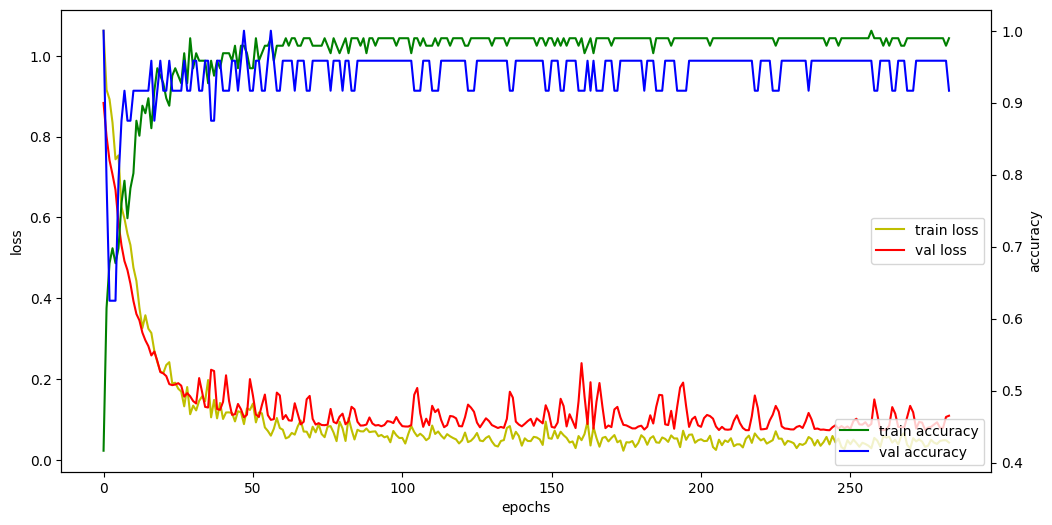

In [46]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [64]:
# 6. 모델 평가(evaluate:테스트셋, 교차표,recall,precision:y실제값,y예측값)
# iris-017-val1.0000.h5 모델도 같이 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
# 학습된 모델
loss, acc = model.evaluate(X_test, Y_test)
loss, acc
# 학습완료된 모델의 recall과 precision을 위해서 실제값과 예측값
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test), axis=1)
recall = recall_score(real, pred, average='weighted') # average='weighted':다중분류
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model accuracy :', acc)
print('model recall :', recall)
print('model precision :', precision)
print('model f1 score :', f1)
# 저장된 모델의 평가
#model2 = load_model('model_iris/iris-017-val1.0000.h5')
#loss, acc = model2.evaluate(X_test, Y_test)
#pred = model2.predict(X_test).argmax(axis=1)
#recall = recall_score(real, pred, average='weighted')
#precision = precision_score(real, pred, average='weighted')
#f1 = f1_score(real, pred, average='weighted')
#print('model2 acc :', acc)
#print('model2 recall :', recall)
#print('model2 precision :', precision)
#print('model2 f1 :', f1)

1/1 [==============================] - 0s 20ms/step
model accuracy : 0.9333333373069763
model recall : 0.9333333333333333
model precision : 0.9435897435897436
model f1 score : 0.933080808080808


In [65]:
# 교차표
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
pd.crosstab(real, pred,
           rownames=['real'], colnames=['pred'])

pred,0,1,2
real,,,
0,7,0,0
1,0,10,2
2,0,0,11


In [66]:
confusion_matrix(real, pred)

array([[ 7,  0,  0],
       [ 0, 10,  2],
       [ 0,  0, 11]], dtype=int64)

In [67]:
# 모델저장 및 사용
save_model(model, 'model/iris.h5')
model.save('model/iris.h5') # tensorflow2.18이상일 경우 확장자를 .keras로도 사용할 수 있음.

In [72]:
# 모델 예측하기
# iris.loc[100] (6.3, 3.3, 6.0, 2.5) 예측하기
result = model.predict([[6.3, 3.3, 6.1, 2.5]])
np.argmax(result) # virginica로 예측

1/1 [==============================] - 0s 37ms/step


2

In [71]:
iris.iloc[::50]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica
